In [62]:
%reset

In [113]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import re
import sys

import mne

In [114]:
print("MNE version is", mne.__version__)
print("Python version is", sys.version)

MNE version is 0.23.3
Python version is 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]


In [118]:
#subj_idx
subjects = ['sub-001', 
                 'sub-003', 
                 'sub-004', 
                 'sub-005', 
                 'sub-006', 
                 'sub-008', 
                 'sub-009', 
                 'sub-010', 
                 'sub-012',
                 'sub-013',
                 'sub-014',
                 'sub-015', 
                 'sub-016',
                 'sub-017']

# task
tasks=[]
for side in ['outside','inside']:
    task='sourcedata-eeg_'+side+'-MRT'
    tasks.append(task)
tasks

#runs
runs=[]
for task in tasks:
    if task == tasks[0]:
        side = 'outside'
        for i in range(1,3):
            run = side+'MRT_run-0'+str(i)+'_beh.tsv'
            runs.append(run)
    else:
        side='inside'
        for i in range(1,6):
            run = side+'MRT_run-0'+str(i)+'_beh.tsv'
            runs.append(run)

#df_dirs
df_dirs=[]
temp_dir =os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))))
BIDS_data="2_Data\\Ostwald2018\\BIDS_data"
datatype='beh'
for subj_idx in subj_idxs :
    for task in tasks:
        if task==tasks[0]:
            for run_index in range(0,2):
                run=runs[run_index]
                run=subj_idx+'_task-pdm_acq-'+run
                df_dir=os.path.join(temp_dir,BIDS_data,subj_idx,task,datatype,run)
                df_dirs.append(df_dir)
        else:
            pass
        
#dfs
dfs=pd.DataFrame()
for df_dir in df_dirs:
    if os.path.exists(df_dir):
        df=pd.read_csv(df_dir,sep='\t')
        subject=''.join(re.findall(r'BIDS_data\\sub-(.+?)\\sourcedata',df_dir))
        side=''.join(re.findall(r'\\sourcedata-eeg_(.+?)-MRT\\beh\\',df_dir))
        run=''.join(re.findall(r'run-0(.+?)_beh',df_dir))
        df['subject']=subject
        df['side']=side
        df['run']=int(run)
        dfs=pd.concat([df,dfs])
    else:
        pass

dfs['attention'] = dfs['prioritization_cue'].map({74:'left',75:'right',76:'double'},na_action=None)
dfs['coherency']=dfs['condition'].map({1:'high',2:'high',3:'low',4:'low'})
dfs['prioritization']=dfs['condition'].map({1:'yes',2:'no',3:'yes',4:'no'})

car_images=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54]
face_images=[19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72]
dfs['category']=dfs['image_index'].isin(car_images).astype(int).map({1:'car', 0:'face'})

bedata = dfs.loc[:,['response_time','response_corr','subject','attention','coherency','prioritization','category']]
bedata['cpp_peak'] = np.nan
bedata['cpp_slope'] = np.nan
bedata['cpp_amplitude'] = np.nan

In [129]:
events = mne.events_from_annotations(edata)[0]

events_id = mne.events_from_annotations(edata)[1]

event_dict = {
  'Response/car': 5,
  'Response/face': 6,
  'Stimulus/hc/p/left': 10,
  'Stimulus/hc/p/right': 11,
  'Stimulus/hc/np/left': 20,
  'Stimulus/hc/np/right': 21,
  'Stimulus/lc/p/left': 30,
  'Stimulus/lc/p/right': 31,
  'Stimulus/lc/np/left': 40,
  'Stimulus/lc/np/right': 41,
  'Cue/Left': 74,
  'Cue/Right': 75,
  'Cue/double': 76
}

cue_dict =  {
  'Cue/Left': 74,
  'Cue/Right': 75,
  'Cue/double': 76
}

stimulus_dict = {
  'Stimulus/hc/p/left': 10,
  'Stimulus/hc/p/right': 11,
  'Stimulus/hc/np/left': 20,
  'Stimulus/hc/np/right': 21,
  'Stimulus/lc/p/left': 30,
  'Stimulus/lc/p/right': 31,
  'Stimulus/lc/np/left': 40,
  'Stimulus/lc/np/right': 41,
}

response_dict = {
  'Response/car': 5,
  'Response/face': 6,
}

for subject in subjects:

    side = 'sourcedata-eeg_outside-MRT'
    
    measures = ['eeg','beh']
    
    etask = os.path.join(subject + "_task-pdm_acq-outsideMRT_eeg.vhdr" )
    
    preprocessed = os.path.join(subject + "_pred.fif")
    
    edata_path = os.path.join(temp_dir, BIDS_data, subject, side, measures[0], etask)
    
    edata = mne.io.read_raw_brainvision(edata_path)

    
    edata.set_channel_types({'EOG':'eog'})   
    
    edata.set_channel_types({'ECG':'ecg'})
    
    edata.resample(512, npad="auto")
    
    edata.filter(1, 30, fir_design='firwin', picks=['eeg'])
    
    edata.set_eeg_reference('average', projection=True).apply_proj()
    
    events_from_annot, event_dict = mne.events_from_annotations(edata)

    
    epochs = mne.Epochs(edata, events_from_annot, event_id=stimulus_dict, tmin=-1, tmax=1,
                     baseline = (None,0), preload=True, picks=['eeg'])
    
    ica = mne.preprocessing.ICA(n_components=50, random_state=97)
    
    ica.fit(epochs) 
    
    ica.exclude = []                                   
    eog_indices, eog_scores = ica.find_bads_eog(edata) 
                                                                         
    ecg_indices, ecg_scores = ica.find_bads_ecg(edata, method='ctps')
                                                                   
    ica.exclude = eog_indices + ecg_indices 
    
    ica.apply(epochs) 

    tname = os.path.join(os.path.dirname(os.getcwd()),'2_4_3_tmp_data',subject+".fif")

    epochs.save(tname,overwrite=True)

    channel = ['CPz','CP1','CP2']

    time = [-0.2, 0]

    epochs_baseline = epochs.copy().pick_channels(channel)

    epochs_baseline = epochs_baseline.crop(time[0],time[1])

    epochs_baseline = epochs_baseline.get_data()

    epochs_baseline = np.mean(epochs_baseline, axis = 1)

    epochs_baseline = np.mean(epochs_baseline, axis = 1)

    epochs_baseline = np.reshape(epochs_baseline, (288,1))

    edata.set_channel_types({'EOG':'eog'})   

    edata.set_channel_types({'ECG':'ecg'})
    
    edata.resample(512, npad="auto")
    
    edata.filter(1, 30, fir_design='firwin', picks=['eeg'])
    
    edata.set_eeg_reference('average', projection=True).apply_proj()
    
    events_from_annot, event_dict = mne.events_from_annotations(edata)

    
    epochs_res = mne.Epochs(edata, events_from_annot, event_id=response_dict, tmin=-1, tmax=1,
                     baseline = (None,0), preload=True, picks=['eeg'])
        
    channel = ['CPz','CP1','CP2']

    time = [-0.25, 0]

    epochs_CPP = epochs_res.copy().pick_channels(channel)

    epochs_CPP = epochs_CPP.crop(time[0],time[1])

    times = epochs_CPP.times

    epochs_CPP = epochs_CPP.get_data()

    epochs_CPP = np.mean(epochs_CPP, axis = 1) - epochs_baseline

    consecutives = []
    
    for trial in range(epochs_CPP.shape[0]):
        ps = []
        for i in range(len(times)):
            t,p = ttest_1samp(epochs_CPP[trial,:],0)
            if p<=0.05:
                p = 1
            else:
                p = 0
            ps = np.append(ps,p)
        start = 0
        end = start + 15
        consecutive = False
        while (end <= len(times)) and (consecutive == False): 
            if np.sum(ps[start:end]) == 15:
                consecutive = True
            else:
                start = start + 1
                end = start + 15
        consecutives = np.append(consecutives,consecutive)

    channel = ['CPz','CP1','CP2']

    time = [-0.25, -0.1]

    epochs_CPP = epochs_res.copy().pick_channels(channel)

    epochs_CPP = epochs_CPP.crop(time[0],time[1])

    times = epochs_CPP.times

    epochs_CPP = epochs_CPP.get_data()

    epochs_CPP = np.mean(epochs_CPP, axis = 1) - epochs_baseline

    CPP_peak = np.amax(epochs_CPP, axis = 1)

    channel = ['CPz','CP1','CP2']

    time = [-0.25, -0.1]


    epochs_CPP = epochs_res.copy().pick_channels(channel)

    epochs_CPP = epochs_CPP.crop(time[0],time[1])

    times = epochs_CPP.times

    epochs_CPP = epochs_CPP.get_data()

    epochs_CPP = np.mean(epochs_CPP, axis = 1) - epochs_baseline

    CPP_slopes = []
    for i in range(epochs_CPP.shape[0]):
        CPP_slope = np.polyfit(times,epochs_CPP[i,:],1)[0]
        CPP_slopes = np.append(CPP_slopes,CPP_slope)

    channel = ['CPz','CP1','CP2']

    time = [-0.1, -0]


    epochs_CPP = epochs_res.copy().pick_channels(channel)

    epochs_CPP = epochs_CPP.crop(time[0],time[1])

    times = epochs_CPP.times

    epochs_CPP = epochs_CPP.get_data()

    epochs_CPP = np.mean(epochs_CPP, axis = 1) - epochs_baseline

    CPP_amplitudes = np.mean(epochs_CPP, axis = 1)

    bedata.loc[bedata['subject']==,'cpp_peak'] = CPP_peak
    bedata.loc[bedata['subject']==,'cpp_slope'] = CPP_slopes
    bedata.loc[bedata['subject']==,'cpp_amplitude'] = CPP_amplitudes

    #rts = np.delete(rts, np.where(consecutives == 0))
    
    #CPP_peak = np.delete(CPP_peak, np.where(consecutives == 0))
    
    #CPP_slopes = np.delete(CPP_slopes, np.where(consecutives == 0))
    
    #CPP_amplitudes = np.delete(CPP_amplitudes, np.where(consecutives == 0))

    

    


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 20', 'Stimulus/S 21', 'Stimulus/S 30', 'Stimulus/S 31', 'Stimulus/S 40', 'Stimulus/S 41', 'Stimulus/S 73', 'Stimulus/S 74', 'Stimulus/S 75', 'Stimulus/S 76', 'SyncStatus/Sync Off']
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 20', 'Stimulus/S 21', 'Stimulus/S 30', 'Stimulus/S 31', 'Stimulus/S 40', 'Stimulus/S 41', 'Stimulus/S 73', 'Stimulus/S 74', 'Stimulus/S 75', 'Stimulus/S 76', 'SyncStatus/Sync Off']
Extracting parameters from d:\yikang1020\yikangsystem1020\2_Data\Ostwald2018\BIDS_data\sub-001\sourcedata-eeg_outside-MRT\eeg\sub-001_task-pdm_acq-outsideMRT_eeg.vhdr...
Setting channel info structure...


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:47: RuntimeWarning: No coordinate information found for channels ['EOG', 'ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  edata = mne.io.read_raw_brainvision(edata_path)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:50: RuntimeWarning: The unit for channel(s) EOG has changed from NA to V.
  edata.set_channel_types({'EOG':'eog'})
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:51: RuntimeWarning: The unit for channel(s) ECG has changed from NA to V.
  edata.set_channel_types({'ECG':'ecg'})


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (3.303 sec)

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 20', 'Stimulus/S 21', 'S

C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:65: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = mne.preprocessing.ICA(n_components=50, random_state=97)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:67: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 50 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 63.3s.
Using EOG channel: EOG
    Applying projection operator with 1 vector (pre-whitener application)
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:76: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)


    Transforming to ICA space (50 components)
    Zeroing out 3 ICA components
    Projecting back using 62 PCA components


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:80: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-001.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(tname,overwrite=True)


Extracting parameters from d:\yikang1020\yikangsystem1020\2_Data\Ostwald2018\BIDS_data\sub-003\sourcedata-eeg_outside-MRT\eeg\sub-003_task-pdm_acq-outsideMRT_eeg.vhdr...
Setting channel info structure...


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:47: RuntimeWarning: No coordinate information found for channels ['EOG', 'ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  edata = mne.io.read_raw_brainvision(edata_path)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:50: RuntimeWarning: The unit for channel(s) EOG has changed from NA to V.
  edata.set_channel_types({'EOG':'eog'})
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:51: RuntimeWarning: The unit for channel(s) ECG has changed from NA to V.
  edata.set_channel_types({'ECG':'ecg'})


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (3.303 sec)

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 20', 'Stimulus/S 21', 'S

C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:65: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = mne.preprocessing.ICA(n_components=50, random_state=97)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:67: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 50 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 51.6s.
Using EOG channel: EOG
    Applying projection operator with 1 vector (pre-whitener application)
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass 

C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:76: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)


    Zeroing out 3 ICA components
    Projecting back using 62 PCA components


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:80: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-003.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(tname,overwrite=True)


Extracting parameters from d:\yikang1020\yikangsystem1020\2_Data\Ostwald2018\BIDS_data\sub-004\sourcedata-eeg_outside-MRT\eeg\sub-004_task-pdm_acq-outsideMRT_eeg.vhdr...
Setting channel info structure...


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:47: RuntimeWarning: No coordinate information found for channels ['EOG', 'ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  edata = mne.io.read_raw_brainvision(edata_path)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:50: RuntimeWarning: The unit for channel(s) EOG has changed from NA to V.
  edata.set_channel_types({'EOG':'eog'})
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:51: RuntimeWarning: The unit for channel(s) ECG has changed from NA to V.
  edata.set_channel_types({'ECG':'ecg'})


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (3.303 sec)

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 20', 'Stimulus/S 21', 'S

C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:65: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = mne.preprocessing.ICA(n_components=50, random_state=97)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:67: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 50 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 31.7s.
Using EOG channel: EOG
    Applying projection operator with 1 vector (pre-whitener application)
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass 

C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:76: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)


    Zeroing out 2 ICA components
    Projecting back using 62 PCA components


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:80: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-004.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(tname,overwrite=True)


Extracting parameters from d:\yikang1020\yikangsystem1020\2_Data\Ostwald2018\BIDS_data\sub-005\sourcedata-eeg_outside-MRT\eeg\sub-005_task-pdm_acq-outsideMRT_eeg.vhdr...
Setting channel info structure...


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:47: RuntimeWarning: No coordinate information found for channels ['EOG', 'ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  edata = mne.io.read_raw_brainvision(edata_path)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:50: RuntimeWarning: The unit for channel(s) EOG has changed from NA to V.
  edata.set_channel_types({'EOG':'eog'})
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:51: RuntimeWarning: The unit for channel(s) ECG has changed from NA to V.
  edata.set_channel_types({'ECG':'ecg'})


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (3.303 sec)

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 20', 'Stimulus/S 21', 'S

C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:65: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = mne.preprocessing.ICA(n_components=50, random_state=97)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:67: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 50 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 50.4s.
Using EOG channel: EOG
    Applying projection operator with 1 vector (pre-whitener application)
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:76: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)


    Transforming to ICA space (50 components)
    Zeroing out 4 ICA components
    Projecting back using 62 PCA components


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:80: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-005.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(tname,overwrite=True)


Extracting parameters from d:\yikang1020\yikangsystem1020\2_Data\Ostwald2018\BIDS_data\sub-006\sourcedata-eeg_outside-MRT\eeg\sub-006_task-pdm_acq-outsideMRT_eeg.vhdr...
Setting channel info structure...


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:47: RuntimeWarning: No coordinate information found for channels ['EOG', 'ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  edata = mne.io.read_raw_brainvision(edata_path)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:50: RuntimeWarning: The unit for channel(s) EOG has changed from NA to V.
  edata.set_channel_types({'EOG':'eog'})
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:51: RuntimeWarning: The unit for channel(s) ECG has changed from NA to V.
  edata.set_channel_types({'ECG':'ecg'})


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (3.303 sec)

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 20', 'Stimulus/S 21', 'S

C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:65: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = mne.preprocessing.ICA(n_components=50, random_state=97)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:67: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 50 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 34.5s.
Using EOG channel: EOG
    Applying projection operator with 1 vector (pre-whitener application)
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:76: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)


    Transforming to ICA space (50 components)
    Zeroing out 2 ICA components
    Projecting back using 62 PCA components


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:80: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-006.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(tname,overwrite=True)


Extracting parameters from d:\yikang1020\yikangsystem1020\2_Data\Ostwald2018\BIDS_data\sub-008\sourcedata-eeg_outside-MRT\eeg\sub-008_task-pdm_acq-outsideMRT_eeg.vhdr...
Setting channel info structure...


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:47: RuntimeWarning: No coordinate information found for channels ['EOG', 'ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  edata = mne.io.read_raw_brainvision(edata_path)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:50: RuntimeWarning: The unit for channel(s) EOG has changed from NA to V.
  edata.set_channel_types({'EOG':'eog'})
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:51: RuntimeWarning: The unit for channel(s) ECG has changed from NA to V.
  edata.set_channel_types({'ECG':'ecg'})


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (3.303 sec)

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 20', 'Stimulus/S 21', 'S

C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:65: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = mne.preprocessing.ICA(n_components=50, random_state=97)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:67: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 50 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 19.6s.
Using EOG channel: EOG
    Applying projection operator with 1 vector (pre-whitener application)
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass 

C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:76: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)


    Transforming to ICA space (50 components)
    Zeroing out 1 ICA component
    Projecting back using 62 PCA components


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:80: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-008.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(tname,overwrite=True)


Extracting parameters from d:\yikang1020\yikangsystem1020\2_Data\Ostwald2018\BIDS_data\sub-009\sourcedata-eeg_outside-MRT\eeg\sub-009_task-pdm_acq-outsideMRT_eeg.vhdr...
Setting channel info structure...


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:47: RuntimeWarning: No coordinate information found for channels ['EOG', 'ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  edata = mne.io.read_raw_brainvision(edata_path)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:50: RuntimeWarning: The unit for channel(s) EOG has changed from NA to V.
  edata.set_channel_types({'EOG':'eog'})
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:51: RuntimeWarning: The unit for channel(s) ECG has changed from NA to V.
  edata.set_channel_types({'ECG':'ecg'})


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (3.303 sec)

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 20', 'Stimulus/S 21', 'S

C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:65: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = mne.preprocessing.ICA(n_components=50, random_state=97)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:67: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 50 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 28.1s.
Using EOG channel: EOG
    Applying projection operator with 1 vector (pre-whitener application)
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass 

C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:76: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)


    Zeroing out 2 ICA components
    Projecting back using 62 PCA components


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:80: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-009.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(tname,overwrite=True)


Extracting parameters from d:\yikang1020\yikangsystem1020\2_Data\Ostwald2018\BIDS_data\sub-010\sourcedata-eeg_outside-MRT\eeg\sub-010_task-pdm_acq-outsideMRT_eeg.vhdr...
Setting channel info structure...


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:47: RuntimeWarning: No coordinate information found for channels ['EOG', 'ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  edata = mne.io.read_raw_brainvision(edata_path)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:50: RuntimeWarning: The unit for channel(s) EOG has changed from NA to V.
  edata.set_channel_types({'EOG':'eog'})
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:51: RuntimeWarning: The unit for channel(s) ECG has changed from NA to V.
  edata.set_channel_types({'ECG':'ecg'})


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (3.303 sec)

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 20', 'Stimulus/S 21', 'S

C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:65: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = mne.preprocessing.ICA(n_components=50, random_state=97)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:67: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 50 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 45.3s.
Using EOG channel: EOG
    Applying projection operator with 1 vector (pre-whitener application)
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:76: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)


    Transforming to ICA space (50 components)
    Zeroing out 4 ICA components
    Projecting back using 62 PCA components


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:80: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-010.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(tname,overwrite=True)


Extracting parameters from d:\yikang1020\yikangsystem1020\2_Data\Ostwald2018\BIDS_data\sub-012\sourcedata-eeg_outside-MRT\eeg\sub-012_task-pdm_acq-outsideMRT_eeg.vhdr...
Setting channel info structure...


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:47: RuntimeWarning: No coordinate information found for channels ['EOG', 'ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  edata = mne.io.read_raw_brainvision(edata_path)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:50: RuntimeWarning: The unit for channel(s) EOG has changed from NA to V.
  edata.set_channel_types({'EOG':'eog'})
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:51: RuntimeWarning: The unit for channel(s) ECG has changed from NA to V.
  edata.set_channel_types({'ECG':'ecg'})


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (3.303 sec)

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 20', 'Stimulus/S 21', 'S

C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:65: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = mne.preprocessing.ICA(n_components=50, random_state=97)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:67: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 50 components


C:\Users\liuyikang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 86.5s.
Using EOG channel: EOG
    Applying projection operator with 1 vector (pre-whitener application)
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower

C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:76: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)


    Transforming to ICA space (50 components)
    Zeroing out 2 ICA components
    Projecting back using 62 PCA components


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:80: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-012.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(tname,overwrite=True)


Extracting parameters from d:\yikang1020\yikangsystem1020\2_Data\Ostwald2018\BIDS_data\sub-013\sourcedata-eeg_outside-MRT\eeg\sub-013_task-pdm_acq-outsideMRT_eeg.vhdr...
Setting channel info structure...


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:47: RuntimeWarning: No coordinate information found for channels ['EOG', 'ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  edata = mne.io.read_raw_brainvision(edata_path)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:50: RuntimeWarning: The unit for channel(s) EOG has changed from NA to V.
  edata.set_channel_types({'EOG':'eog'})
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:51: RuntimeWarning: The unit for channel(s) ECG has changed from NA to V.
  edata.set_channel_types({'ECG':'ecg'})


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (3.303 sec)

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 20', 'Stimulus/S 21', 'S

C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:65: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = mne.preprocessing.ICA(n_components=50, random_state=97)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:67: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 50 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 27.4s.
Using EOG channel: EOG
    Applying projection operator with 1 vector (pre-whitener application)
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:76: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)


    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (50 components)
    Zeroing out 3 ICA components
    Projecting back using 62 PCA components


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:80: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-013.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(tname,overwrite=True)


Extracting parameters from d:\yikang1020\yikangsystem1020\2_Data\Ostwald2018\BIDS_data\sub-014\sourcedata-eeg_outside-MRT\eeg\sub-014_task-pdm_acq-outsideMRT_eeg.vhdr...
Setting channel info structure...


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:47: RuntimeWarning: No coordinate information found for channels ['EOG', 'ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  edata = mne.io.read_raw_brainvision(edata_path)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:50: RuntimeWarning: The unit for channel(s) EOG has changed from NA to V.
  edata.set_channel_types({'EOG':'eog'})
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:51: RuntimeWarning: The unit for channel(s) ECG has changed from NA to V.
  edata.set_channel_types({'ECG':'ecg'})


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (3.303 sec)

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 20', 'Stimulus/S 21', 'S

C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:65: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = mne.preprocessing.ICA(n_components=50, random_state=97)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:67: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 50 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 31.7s.
Using EOG channel: EOG
    Applying projection operator with 1 vector (pre-whitener application)
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:76: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)


    Transforming to ICA space (50 components)
    Zeroing out 1 ICA component
    Projecting back using 62 PCA components


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:80: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-014.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(tname,overwrite=True)


Extracting parameters from d:\yikang1020\yikangsystem1020\2_Data\Ostwald2018\BIDS_data\sub-015\sourcedata-eeg_outside-MRT\eeg\sub-015_task-pdm_acq-outsideMRT_eeg.vhdr...
Setting channel info structure...


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:47: RuntimeWarning: No coordinate information found for channels ['EOG', 'ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  edata = mne.io.read_raw_brainvision(edata_path)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:50: RuntimeWarning: The unit for channel(s) EOG has changed from NA to V.
  edata.set_channel_types({'EOG':'eog'})
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:51: RuntimeWarning: The unit for channel(s) ECG has changed from NA to V.
  edata.set_channel_types({'ECG':'ecg'})


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (3.303 sec)

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 20', 'Stimulus/S 21', 'S

C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:65: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = mne.preprocessing.ICA(n_components=50, random_state=97)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:67: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 50 components


C:\Users\liuyikang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 88.1s.
Using EOG channel: EOG
    Applying projection operator with 1 vector (pre-whitener application)
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower

C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:76: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)


    Transforming to ICA space (50 components)
    Zeroing out 4 ICA components
    Projecting back using 62 PCA components


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:80: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-015.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(tname,overwrite=True)


Extracting parameters from d:\yikang1020\yikangsystem1020\2_Data\Ostwald2018\BIDS_data\sub-016\sourcedata-eeg_outside-MRT\eeg\sub-016_task-pdm_acq-outsideMRT_eeg.vhdr...
Setting channel info structure...


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:47: RuntimeWarning: No coordinate information found for channels ['EOG', 'ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  edata = mne.io.read_raw_brainvision(edata_path)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:50: RuntimeWarning: The unit for channel(s) EOG has changed from NA to V.
  edata.set_channel_types({'EOG':'eog'})
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:51: RuntimeWarning: The unit for channel(s) ECG has changed from NA to V.
  edata.set_channel_types({'ECG':'ecg'})


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (3.303 sec)

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 20', 'Stimulus/S 21', 'S

C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:65: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = mne.preprocessing.ICA(n_components=50, random_state=97)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:67: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 50 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 15.8s.
Using EOG channel: EOG
    Applying projection operator with 1 vector (pre-whitener application)
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass 

C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:76: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)


    Transforming to ICA space (50 components)
    Zeroing out 1 ICA component
    Projecting back using 62 PCA components


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:80: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-016.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(tname,overwrite=True)


Extracting parameters from d:\yikang1020\yikangsystem1020\2_Data\Ostwald2018\BIDS_data\sub-017\sourcedata-eeg_outside-MRT\eeg\sub-017_task-pdm_acq-outsideMRT_eeg.vhdr...
Setting channel info structure...


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:47: RuntimeWarning: No coordinate information found for channels ['EOG', 'ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  edata = mne.io.read_raw_brainvision(edata_path)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:50: RuntimeWarning: The unit for channel(s) EOG has changed from NA to V.
  edata.set_channel_types({'EOG':'eog'})
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:51: RuntimeWarning: The unit for channel(s) ECG has changed from NA to V.
  edata.set_channel_types({'ECG':'ecg'})


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (3.303 sec)

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 20', 'Stimulus/S 21', 'S

C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:65: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = mne.preprocessing.ICA(n_components=50, random_state=97)
C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:67: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 50 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 43.5s.
Using EOG channel: EOG
    Applying projection operator with 1 vector (pre-whitener application)
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass 

C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:76: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs)


    Transforming to ICA space (50 components)
    Zeroing out 2 ICA components
    Projecting back using 62 PCA components


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/826381201.py:80: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-017.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(tname,overwrite=True)


In [177]:
subject

'sub-017'

In [182]:
re.findall(r'sub-(.+?)',subject)

['0']

Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_7552/240076364.py:6: RuntimeWarning: Some values in overlay_times fall outside of the epochs time interval (between -1.0 s and 1.0 s)
  epochs.plot_image(picks = ['CPz','CP1','CP2'],


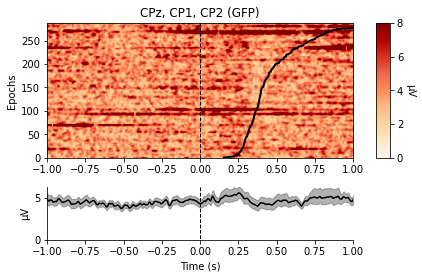

[<Figure size 432x288 with 3 Axes>]

In [159]:
rts = bedata.loc[bedata['subject']=='017','response_time'].to_numpy()

order = rts.argsort()


epochs.plot_image(picks = ['CPz','CP1','CP2'],
                  order=order, 
                  sigma=2,
                  overlay_times=rts, 
                  combine='gfp',
                  cmap = 'OrRd',
                  vmin = 0,
                  vmax = 8)

AttributeError: 'Epochs' object has no attribute 'nave'

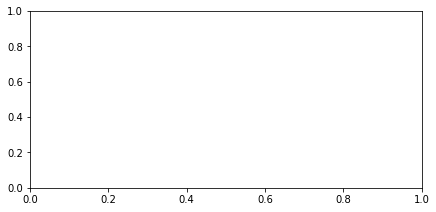

### h1: There is a process of evidence accumulation in face-car paradigm


### h2: The role of attention in evidence accumulation

### h3: Multiverse analysis of joint modeling EEG and behavior